# Figure 6f-j: Encoding models for auditory cortex recordings

In [1]:
import h5py
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os

from neuropacks import ECOG
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from neuroinference.encoding_utils import calculate_best_frequencies_ecog
from neuroinference.utils import (plot_metric_summary,
                                  calculate_selection_ratio,
                                  append_cb_ax)

%matplotlib inline

## Read in data and model fits

In [2]:
dead_electrodes = [0, 19, 21]

In [3]:
# read in AC recordings
data_path = os.path.join(os.environ['HOME'], 'data/ecog/r32_b7.mat')
grid_path = os.path.join(os.environ['HOME'], 'data/ecog/grdid.mat')
ecog = ECOG(data_path=data_path, grid_path=grid_path)

In [4]:
# read in AC model fits
fits_path = os.path.join(os.environ['HOME'], 'fits/uoineuro/tuning/ecog/ecog_tuning.h5')
fits = h5py.File(fits_path, 'r')

## Figure 6f: Tuning curves on a subset of the $\mu$-electrocorticography grid

In [5]:
baseline_coefs = np.mean(fits['lasso/tuning_coefs'], axis=0)
baseline_intercepts = np.mean(fits['lasso/intercepts'], axis=0)

uoi_coefs = np.mean(fits['uoi_lasso_bic/tuning_coefs'], axis=0)
uoi_intercepts = np.mean(fits['uoi_lasso_bic/intercepts'], axis=0)

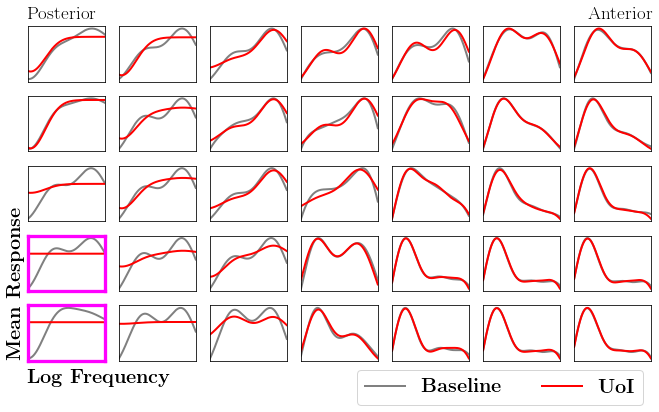

In [8]:
fig, axes = plt.subplots(5, 7, figsize=(9, 5))

# iterate over electrodes
for electrode in range(ecog.n_electrodes):
    # get grid position from electrode index
    x, y = ecog.get_xy_for_electrode(electrode)
    
    # only visualize electrodes from a particular subset of the grid
    if (x >= 2) and (x <= 6) and (y >= 0) and (y <= 6):
        x -= 2
        y -= 0
        ax = axes[x, y]

        # empty plots for dead electrodes
        if electrode in dead_electrodes:
            ax.axis('off')
            ax.set_xticks([])
            ax.set_yticks([])
            continue

        # calculate tuning curves for frequency values
        frequencies = np.linspace(ecog.freq_set[0], ecog.freq_set[-1], 100000)
        _, baseline_tc = ecog.get_tuning_curve(tuning_coefs=baseline_coefs[electrode],
                                            frequencies=frequencies)
        _, uoi_tc = ecog.get_tuning_curve(tuning_coefs=uoi_coefs[electrode],
                                              frequencies=frequencies)
        
        # plot the tuning curves for baseline/UoI fits
        ax.plot(
            frequencies, baseline_intercepts[electrode] + baseline_tc,
            color='gray',
            linewidth=2,
            alpha=1,
            zorder=-1,
            label=r'\textbf{Baseline}')
        axes[x, y].plot(
             frequencies, uoi_intercepts[electrode] + uoi_tc,
             color='red',
             linewidth=2,
             alpha=1,
             label=r'\textbf{UoI}')

        # scale x-axis, set limits, and remove tick labels
        ax.set_xscale('log')
        ax.set_xlim([frequencies[0], frequencies[-1]])
        ax.set_xticks([])
        ax.set_yticks([])

# identify electrodes that have intercept models
for ax in [axes[-1, 0], axes[-2, 0]]:
    for _, spine in ax.spines.items():
        spine.set_color('fuchsia')
        spine.set_linewidth(3.3)

plt.tight_layout()

# plot axes labels
fig.text(
    x=0.02, y=-0.01,
    s=r'\textbf{Log Frequency}',
    horizontalalignment='left',
    verticalalignment='center',
    fontsize=20)
fig.text(
    x=-0.01, y=0.255,
    s=r'\textbf{Mean Response}',
    horizontalalignment='left',
    verticalalignment='center',
    fontsize=20,
    rotation=90)
# plot anterior/posterior labels
fig.text(
    x=0.985, y=1.0,
    s=r'Anterior',
    horizontalalignment='right',
    verticalalignment='center',
    fontsize=19)
fig.text(
    x=0.02, y=1.0,
    s=r'Posterior',
    horizontalalignment='left',
    verticalalignment='center',
    fontsize=19)
# plot legend
axes[0, 0].legend(
    loc='lower center',
    bbox_transform=fig.transFigure,
    bbox_to_anchor=(0.75, -0.11),
    ncol=3,
    fancybox=True,
    prop={'size': 20})

plt.savefig('ecog_tuning_grid.pdf', bbox_inches='tight')

## Figure 6g-j: Comparison of tuning models

In [7]:
baseline = fits['lasso']
uoi = fits['uoi_lasso_bic']

In [8]:
# calculate selection ratios, and read in performance metrics
baseline_srs = np.mean(calculate_selection_ratio(baseline['tuning_coefs']), axis=0)
baseline_r2s = np.mean(baseline['r2'], axis=0)
baseline_bics = np.mean(baseline['BIC'], axis=0)
uoi_srs = np.mean(calculate_selection_ratio(uoi['tuning_coefs']), axis=0)
uoi_r2s = np.mean(uoi['r2'], axis=0)
uoi_bics = np.mean(uoi['BIC'], axis=0)

In [9]:
# remove dead electrodes from datasets
baseline_srs = np.delete(baseline_srs, dead_electrodes)
baseline_r2s = np.delete(baseline_r2s, dead_electrodes)
baseline_bics = np.delete(baseline_bics, dead_electrodes)
uoi_srs = np.delete(uoi_srs, dead_electrodes)
uoi_r2s = np.delete(uoi_r2s, dead_electrodes)
uoi_bics = np.delete(uoi_bics, dead_electrodes)

In [10]:
# determine which models are intercept models
baseline_zero_sels = np.argwhere(baseline_srs == 0).ravel()
uoi_zero_sels = np.argwhere(uoi_srs == 0).ravel()

In [11]:
# baseline GPR predictor for selection ratio vs R2
xvals = np.linspace(-0.001, 0.078)
kernel = RBF(length_scale=0.01) + WhiteKernel(noise_level=0.1)
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.)
gpr.fit(baseline_r2s.reshape(-1, 1), baseline_srs)
baseline_mean_at_zero, baseline_std_at_zero = gpr.predict(np.array([[0]]), return_std=True)
print('Baseline: ', baseline_mean_at_zero[0], '+/-', baseline_std_at_zero[0])

Baseline:  0.358475215992641 +/- 0.10994123825341658


In [12]:
# uoi GPR predictor for selection ratio vs R2
kernel = RBF(length_scale=0.01) + WhiteKernel(noise_level=0.1)
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.)
gpr.fit(uoi_r2s.reshape(-1, 1), uoi_srs)
uoi_mean_at_zero, uoi_std_at_zero = gpr.predict(np.array([[0]]), return_std=True)
print('UoI: ', uoi_mean_at_zero[0], '+/-', uoi_std_at_zero[0])

UoI:  0.12344762508601548 +/- 0.10242972316038122


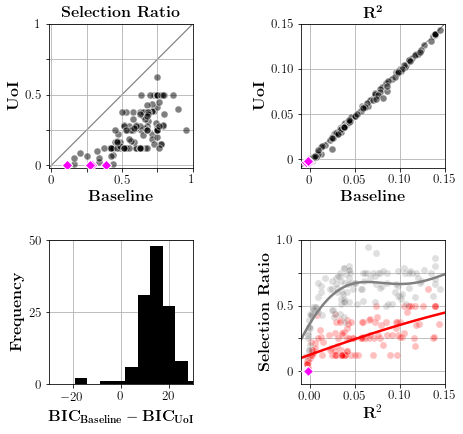

In [15]:
# figure and subplot dimensions
figsize = 6 # inches
subplotsize = 2 # inches
v_spacing = 1. # inches
h_spacing = 1.5

# create figure and subplots
fig = plt.figure(figsize=(6, 6))
# selection ratios
srs = fig.add_axes([0, (subplotsize + v_spacing) / figsize,
                    subplotsize / figsize, subplotsize / figsize])
# predictive performance
pp = fig.add_axes([(subplotsize + h_spacing) / figsize, (subplotsize + v_spacing) / figsize,
                   subplotsize / figsize, subplotsize / figsize])
# bayesian information criterion
bics = fig.add_axes([0, 0,
                     subplotsize / figsize, subplotsize / figsize])
# split plot requires three separate axes
sel_vs_r2 = fig.add_axes([(subplotsize + h_spacing) / figsize, 0,
                          subplotsize / figsize, subplotsize / figsize])

# selection ratios
srs.scatter(
    baseline_srs,
    uoi_srs,
    alpha=0.50,
    s=50,
    color='k',
    edgecolor='white')
# highlight empty ratios by UoI
srs.scatter(
    baseline_srs[uoi_zero_sels],
    uoi_srs[uoi_zero_sels],
    alpha=1.,
    s=55,
    color='fuchsia',
    edgecolor='white',
    marker='D',
    zorder=1000)

srs.set_xlim([-0.02, 1])
srs.set_xticks([0., 0.25, 0.5, 0.75, 1.0])
srs.set_xticklabels(['0', '', '0.5', '', '1'])

# plot r2 values
pp.scatter(
    baseline_r2s,
    uoi_r2s,
    alpha=0.50,
    s=50,
    color='black',
    edgecolor='white')

# highlight empty models by UoI
pp.scatter(
    baseline_r2s[uoi_zero_sels],
    uoi_r2s[uoi_zero_sels],
    alpha=1.0,
    s=55,
    color='fuchsia',
    edgecolor='white',
    marker='D',
    zorder=1000)

pp.set_xlim([-0.01, 0.15])
pp.set_xticks([0., 0.05, 0.1, 0.15])
pp.set_xticklabels(['0', '0.05', '0.10', '0.15'])

# top row: make scatter plots uniform
for ax in [srs, pp]:
    ax.set_ylim(ax.get_xlim())
    ax.set_yticks(ax.get_xticks())
    ax.set_yticklabels(ax.get_xticklabels())
    ax.plot(
        ax.get_xlim(), ax.get_ylim(),
        color='gray',
        linewidth=1.2,
        zorder=-1)
    
# compare difference in BIC
bics.hist(baseline_bics - uoi_bics, color='k')

bics.set_xlim([-30, 30])
bics.set_ylim([0, 50])
bics.set_yticks([0, 25, 50])

# compare r2 to selection ratio
sel_vs_r2.scatter(
    uoi_r2s,
    uoi_srs,
    s=50,
    color='red',
    edgecolor='white',
    alpha=0.25)

sel_vs_r2.scatter(
    baseline_r2s,
    baseline_srs,
    s=50,
    color='gray',
    edgecolor='white',
    alpha=0.25)

sel_vs_r2.scatter(
    uoi_r2s[uoi_zero_sels],
    uoi_srs[uoi_zero_sels],
    alpha=1.0,
    s=50,
    color='fuchsia',
    edgecolor='white',
    marker='D',
    zorder=1000)

# plot trendlines
xvals = np.linspace(-0.01, 0.15)
kernel = RBF(length_scale=0.01) + WhiteKernel(noise_level=0.1)
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.)
gpr.fit(baseline_r2s.reshape(-1, 1), baseline_srs)
y_gpr, y_std = gpr.predict(xvals.reshape(-1, 1), return_std=True)
sel_vs_r2.plot(xvals, y_gpr,
               color='gray',
               linewidth=2.5)

kernel = RBF(length_scale=0.01) + WhiteKernel(noise_level=0.1)
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.)
gpr.fit(uoi_r2s.reshape(-1, 1), uoi_srs)
y_gpr, y_std = gpr.predict(xvals.reshape(-1, 1), return_std=True)
sel_vs_r2.plot(xvals, y_gpr,
               color='red',
               linewidth=2.5)

sel_vs_r2.set_xlim([-0.01, 0.15])
sel_vs_r2.set_xticks([0., 0.05, 0.1, 0.15])
sel_vs_r2.set_yticklabels(['0', '', '0.5', '', '1.0'])
sel_vs_r2.set_ylim([-0.1, 1.0])
sel_vs_r2.set_yticks([0, 0.25, 0.50, 0.75, 1.0])

# stylize plots
for ax in [srs, pp, bics, sel_vs_r2]:
    ax.grid('on')
    ax.set_axisbelow(True)
    
for ax in [srs, pp, bics, sel_vs_r2]:
    ax.tick_params(labelsize=13)

# labels
srs.set_xlabel(r'\textbf{Baseline}', fontsize=16)
srs.set_ylabel(r'\textbf{UoI}', fontsize=16)
pp.set_xlabel(r'\textbf{Baseline}', fontsize=16)
pp.set_ylabel(r'\textbf{UoI}', fontsize=16)
bics.set_xlabel(
    r'$\textbf{BIC}_{\normalsize\textbf{Baseline}} - \textbf{BIC}_{\normalsize\textbf{UoI}}$',
    fontsize=16,
    labelpad=10)
bics.set_ylabel(
    r'\textbf{Frequency}',
    fontsize=16)
sel_vs_r2.set_xlabel(r'$\mathbf{R}^2$',
                   fontsize=16)
sel_vs_r2.set_ylabel(r'\textbf{Selection Ratio}',
                   fontsize=16)


# titles
srs.set_title(r'\textbf{Selection Ratio}', fontsize=16)
pp.set_title(r'$\mathbf{R^2}$', fontsize=16)

plt.savefig('ecog_tuning_metrics.pdf', bbox_inches='tight')